# Data Scientist Assessment Test

The next notebook will present the Data Scientist Assessment test for the Melonn Company.

In this, we'll have to predict the monthly sales of a company in order to help them to efficiently contract the required personal

Presented by: Yorley Palacios

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import floor

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [3]:
#libraries for plotting
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
data = pd.read_csv(r'./Datos_Prueba_DataScientist.csv')

In [5]:
data.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153275 entries, 0 to 153274
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OrderId         153275 non-null  object
 1   RequestTime     153275 non-null  object
 2   DeliveryOption  153275 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB


In [7]:
data.RequestTime = pd.to_datetime(data.RequestTime, format='%Y%m%d %H:%M:%S', errors='raise')

In [8]:
data.DeliveryOption.unique()

array(['Mismo dia entre 6:30 pm y 8:30 pm',
       'Siguiente dia entre 12:30 pm y 2:30 pm',
       'Siguiente dia entre las 6:30 pm y 8:30 pm'], dtype=object)

In [9]:
data['Delivery_Day'] = [x if y == 'Mismo dia entre 6:30 pm y 8:30 pm'  else x + timedelta(days=1) for (x,y) in zip(data.RequestTime,data.DeliveryOption)]
data['Delivery_Day'] = data.Delivery_Day.dt.date

In [10]:
data['enlisted_shift'] = ['Afternoon' if x == 'Mismo dia entre 6:30 pm y 8:30 pm' else 'Morning' for x in data.DeliveryOption]

In [11]:
data['Order']        = 1
data['RequestTime']  = pd.to_datetime(data['RequestTime'], format='%Y-%m-%d', errors='raise')
data['Month']        = data['RequestTime'].dt.month
data['Year']         = data['RequestTime'].dt.year
data['Day']          = data['RequestTime'].dt.weekday

In [12]:
data.head()

,OrderId,RequestTime,DeliveryOption,Delivery_Day,enlisted_shift,Order,Month,Year,Day
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon,1,1,2018,0
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon,1,1,2018,0
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon,1,1,2018,0
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02,Morning,1,1,2018,0
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02,Morning,1,1,2018,0


In [13]:
table = pd.pivot_table(data, values='OrderId', index=['Delivery_Day'],
                    columns=['enlisted_shift'], aggfunc=np.count_nonzero)
table.fillna(0, inplace = True)
table

enlisted_shift,Afternoon,Morning
Delivery_Day,,
2018-01-01,8.0,0.0
2018-01-02,7.0,10.0
2018-01-03,8.0,12.0
2018-01-04,9.0,12.0
2018-01-05,9.0,10.0
...,...,...
2021-02-25,91.0,82.0
2021-02-26,118.0,70.0
2021-02-27,162.0,98.0


In [14]:
table['Total'] = table['Afternoon'] + table['Morning']
table.head()

enlisted_shift,Afternoon,Morning,Total
Delivery_Day,,,
2018-01-01,8.0,0.0,8.0
2018-01-02,7.0,10.0,17.0
2018-01-03,8.0,12.0,20.0
2018-01-04,9.0,12.0,21.0
2018-01-05,9.0,10.0,19.0


In [15]:
table.describe()

enlisted_shift,Afternoon,Morning,Total
count,1156.000000,1156.000000,1156.00000
mean,75.086505,57.504325,132.59083
std,45.676742,32.894255,75.46650
min,0.000000,0.000000,8.00000
25%,41.000000,33.000000,74.00000
50%,68.000000,53.000000,125.00000
75%,102.000000,77.250000,182.00000
max,275.000000,197.000000,431.00000


array([<AxesSubplot:xlabel='Delivery_Day'>,
       <AxesSubplot:xlabel='Delivery_Day'>,
       <AxesSubplot:xlabel='Delivery_Day'>], dtype=object)

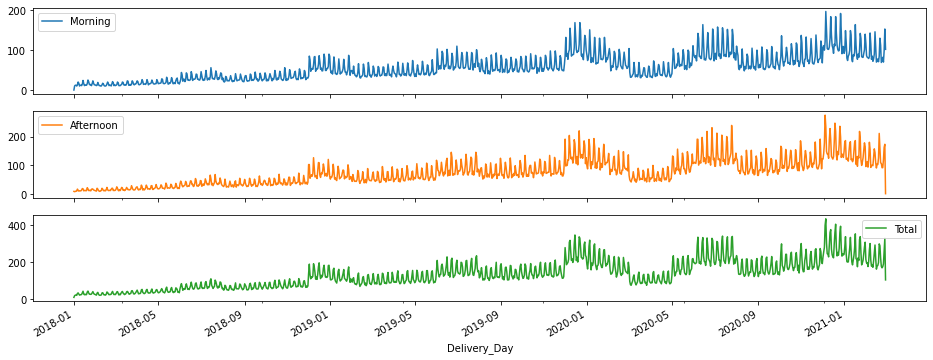

In [16]:
table[['Morning','Afternoon','Total']].plot(figsize= (16,6), subplots = True)

The graph reveals a very interesting behavior, a growing trend can be observed, as well as a seasonality, of about 6 months. The peaks so close together may also be a shorter term trend behavior. let's look at this seasonality in more detail.

In [17]:
table2 = table.copy()
table2.reset_index(inplace = True)
table2['Delivery_Day'] = pd.to_datetime(table2['Delivery_Day'], format='%Y-%m-%d', errors='raise')
table2['Year']  = table2.Delivery_Day.dt.year
table2['Month'] = table2.Delivery_Day.dt.month

group = table2.groupby(['Year','Month'])
temp1 = group['Total'].sum()
temp2 = group['Delivery_Day'].last()
temp3 = pd.concat([temp1, temp2], axis = 1)
temp3.reset_index(inplace = True)
temp3.set_index('Delivery_Day', inplace = True)

[Text(0, 0.5, 'Orders'), Text(0.5, 0, 'Month')]

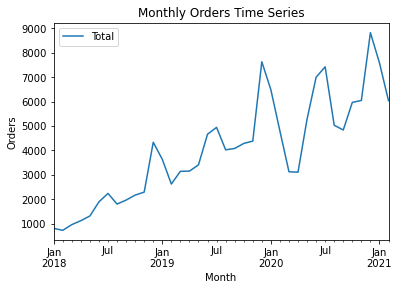

In [18]:
temp3.iloc[0:38].plot( y ='Total')

plt.title("Monthly Orders Time Series")
plt.gca().set(ylabel='Orders', xlabel='Month')

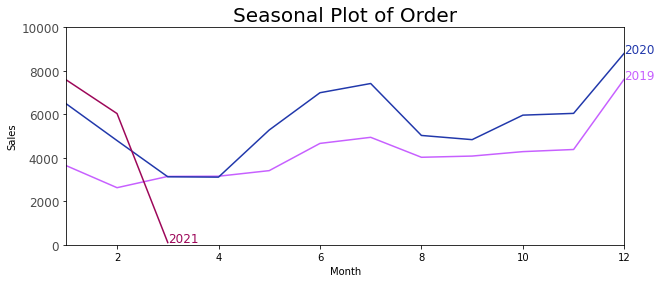

In [19]:
years = temp3['Year'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(10,4))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('Month', 'Total', data=temp3.loc[temp3.Year==y, :], color=mycolors[i], label=y)
        plt.text(temp3.loc[temp3.Year==y, :].shape[0], temp3.loc[temp3.Year==y, 'Total'][-1:].values[0], y, fontsize=12, color=mycolors[i])


plt.gca().set(xlim=(1, 12), ylim=(0, 10000), ylabel='Sales', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Order", fontsize=20)
plt.show()
del temp3

In [20]:
temp4 = data.copy()
temp4['Order']        = 1
temp4['RequestTime']  = pd.to_datetime(temp4['RequestTime'], format='%Y-%m-%d', errors='raise')
temp4['Month']        = temp4['RequestTime'].dt.month
temp4['Year']         = temp4['RequestTime'].dt.year
temp4['Day']          = temp4['RequestTime'].dt.weekday

temp4                 = temp4.groupby(['Month','Day'])
temp4                 = temp4['Order'].sum()
temp4                 = temp4.reset_index()
temp4.head()

,Month,Day,Order
0,1,0,1918
1,1,1,2096
2,1,2,2271
3,1,3,2297
4,1,4,2877


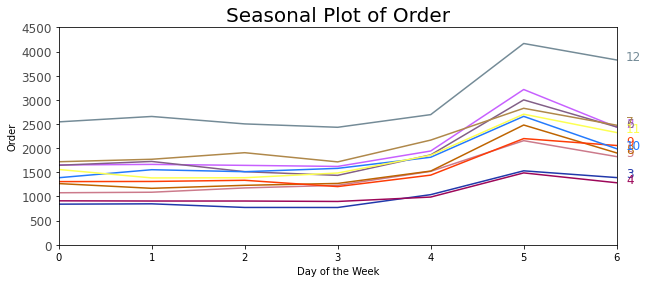

In [21]:
months = temp4['Month'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(months), replace=False)

plt.figure(figsize=(10,4))
for i, m in enumerate(months):
    if i > 0:        
        plt.plot('Day', 'Order', data=temp4.loc[temp4.Month==m, :], color=mycolors[i], label=m)
        plt.text(temp4.loc[temp4.Month==m, :].shape[0]-0.9, temp4.loc[temp4.Month==m, 'Order'][-1:].values[0], m, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(0, 6), ylim=(0, 4500), ylabel='Order', xlabel='Day of the Week')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Order", fontsize=20)
plt.show()

Since the data is a time series with well defined seasonalities, we'll try an statistic model to predict the orders. So the model use will be a SARIMAX, that take into account the seasonalities we found and exogenous variables like the affectednes of COVID

## Modelling - SARIMAX

in order to use properly the SARIMAX model, we need to estimate the parameters p,d,q for the terms of the model

### Finding d

let's check if the model is stationery

In [22]:
result = adfuller(table.Total.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.116823
p-value: 0.237804


The P-Value is higher than the significance level, so we must procede to diffentiate the serie to make stationery.

<Figure size 1800x144 with 0 Axes>

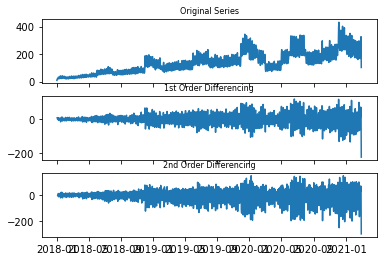

In [23]:
# Original Series
plt.figure(figsize=(25,2))
fig, axes = plt.subplots(3, sharex=True)

axes[0].plot(table.Total); axes[0].set_title('Original Series', fontsize = 8)
#plot_acf(temp.Total, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(table.Total.diff()); axes[1].set_title('1st Order Differencing', fontsize = 8)
#plot_acf(temp.Total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2].plot(table.Total.diff(2).diff()); axes[2].set_title('2nd Order Differencing', fontsize = 8)
#plot_acf(temp.Total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<Figure size 432x144 with 0 Axes>

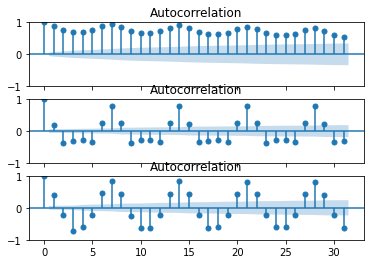

In [24]:
# Original Series
plt.figure(figsize=(6,2))
fig, axes = plt.subplots(3, sharex=True)

plot_acf(table.Total, ax=axes[0])

# 1st Differencing
plot_acf(table.Total.diff().dropna(), ax=axes[1])

# 2nd Differencing
plot_acf(table.Total.diff(3).diff().dropna(), ax=axes[2])

plt.show()

For the above series, the time series reaches stationarity with one orders of differencing.
d = 1

In [25]:
temp = table.copy()
temp.reset_index(inplace = True)

### Finding p

let's check in the PACF, what lags are over the significance level

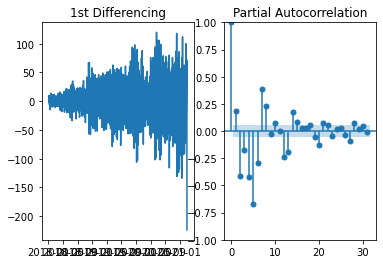

In [26]:
fig, axes = plt.subplots(1, 2,)
axes[0].plot(table.Total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(table.Total.diff().dropna(), ax=axes[1],method='ywm')

plt.show()

It is noted that lag 1 is highly significant, so it is assumed that it is decided to set p to 1.

### Finding q

let's check in the ACF what lags are over the significance level

<Figure size 2160x144 with 0 Axes>

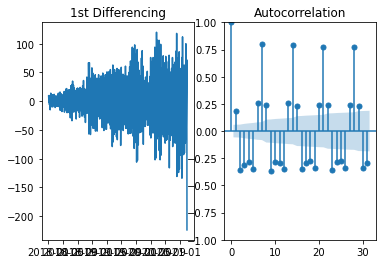

In [28]:
plt.figure(figsize=(15,2))
fig, axes = plt.subplots(1, 2)
axes[0].plot(table.Total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(table.Total.diff().dropna(), ax=axes[1])

plt.show()

it can be seen that lag 1 is above the significance level, so it is decided to assume the q value to be 1, and the significance of the weekly lags can also be seen, which can be verified in the following graph.

<Figure size 1080x144 with 0 Axes>

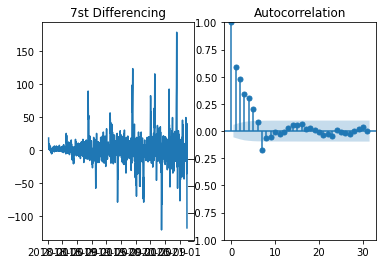

In [29]:
plt.figure(figsize=(15,2))
fig, axes = plt.subplots(1, 2)
axes[0].plot(table.Total.diff(7)); axes[0].set_title('7st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(table.Total.diff(7).dropna(), ax=axes[1])

plt.show()

When using a lag of 7, it is observed that the series behaves in a stationary manner. Therefore, it is decided to take this factor into account in the model

so, we have tha the order of the ARIMA model is (1,1,1),
for the seasonal component we will try some combinations.

another topic to address is the multiple seasonalities, we have a weekly one and a semestral one. Since the SARIMAX model can only work with one, we'll include the weekly one, and for the semestral, we can utilize exogenous variables in SARIMAX to model additional seasonalities with Fourier terms.

In [30]:
Y    = table.Total.copy()

In [31]:
exog = table.copy()
exog.reset_index(inplace = True)
exog.Delivery_Day = pd.to_datetime(exog.Delivery_Day, format='%Y-%m-%d', errors='raise')
exog['month']     = exog.Delivery_Day.dt.month
exog['year']      = exog.Delivery_Day.dt.year
exog              = exog.set_index(pd.PeriodIndex(exog['Delivery_Day'], freq='D'))
exog['sin180']    = np.sin(2 * np.pi * exog.index.dayofyear / 180)
exog['cos180']    = np.cos(2 * np.pi * exog.index.dayofyear / 180)
#exog['sin180_2']  = np.sin(4 * np.pi * exog.index.dayofyear / 180)
#exog['cos180_2']  = np.cos(4 * np.pi * exog.index.dayofyear / 180)
exog              = exog.drop(columns=['Delivery_Day', 'Afternoon', 'Morning', 'Total'])

In [32]:
## building data of affectednessof sales by COVID-19
# for the month prior to COVID-19 the impact is zero
impact = {'2020-03-01':3,'2020-04-01':3,'2020-05-01':1,'2020-06-01':1,
'2020-07-01':1,'2020-08-01':2,'2020-09-01':2,'2020-10-01':1,
'2020-11-01':1,'2020-12-01':2,'2021-01-01':2,'2021-02-01':1, '2021-03-01':0}
impact          = pd.DataFrame(impact.items(), columns=['date', 'affectednes'])
impact.date     = pd.to_datetime(impact.date, format='%Y-%m-%d', errors='raise')
impact['year']  = impact.date.dt.year
impact['month'] = impact.date.dt.month
impact.head(1)

,date,affectednes,year,month
0,2020-03-01,3,2020,3


In [33]:
exog = exog.merge(impact[['affectednes','year','month']], how='left', on=['year','month'])
exog.affectednes.fillna(0, inplace= True)
exog = exog.drop(['year','month'], axis = 1)
exog.set_index(Y.index, inplace = True)
exog.head(1)

,sin180,cos180,affectednes
Delivery_Day,,,
2018-01-01,0.034899,0.999391,0.0


### Spliting Data
We'll use the 75% of the data to train

In [34]:
train_size  = int(Y.shape[0]*0.75)
Y_Train     = Y.iloc[0:train_size]
exog_train  = exog.iloc[0:train_size]

Y_test    = Y.iloc[(train_size):]
exog_test = exog.iloc[(train_size):]

In [35]:
Y_test.shape

(289,)

after some iterations, the order that gives the best model is (2, 1, 1)

In [36]:
%%time
sxmodel = SARIMAX(Y_Train, exog = exog_train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 52) )
results = sxmodel.fit()

C:\Users\Ecsim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Ecsim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Ecsim\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wall time: 2min 50s


In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  867
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -3645.294
Date:                            Sun, 01 May 2022   AIC                           7308.589
Time:                                    14:57:32   BIC                           7350.906
Sample:                                01-01-2018   HQIC                          7324.832
                                     - 05-16-2020                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sin180          3.7737      5.207      0.725      0.469      -6.432      13.979
cos180         25.7680      5.324      4.840      0.000      15.333      36.203
affectednes   -14.4710      4.080     -3.547      0.000     -22.467      -6.475
ar.L1           0.8861      0.028     31.515      0.000       0.831       0.941
ar.L2          -0.6585      0.029    -22.598      0.000      -0.716      -0.601
ma.L1          -0.8612      0.015    -56.245      0.000      -0.891      -0.831
ar.S.L52        0.1658      0.053      3.116      0.002       0.062       0.270
ma.S.L52       -0.9985      3.676     -0.272      0.786      -8.203       6.206
sigma2        388.0393   1416.410      0.274      0.784   -2388.074    3164.152
===================================================================================
Ljung-Box (L1) (Q):                  11.66   Jarque-Bera (JB):               206.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
y_pred = results.predict(exog=exog_train)

<AxesSubplot:>

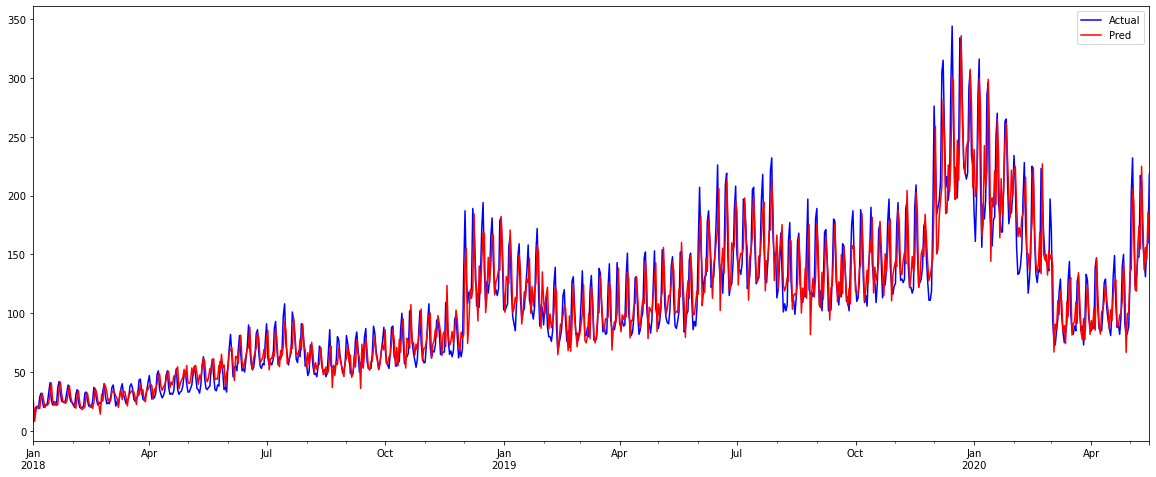

In [39]:
predictions=pd.DataFrame(y_pred)
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
predictions['Actual'] = Y_Train

predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

The model is well fitted to the training data!

let's the check now in the test data.

In [40]:
prediction = results.get_forecast(steps=289, exog=exog_test)
y_pred     = prediction.predicted_mean

<AxesSubplot:>

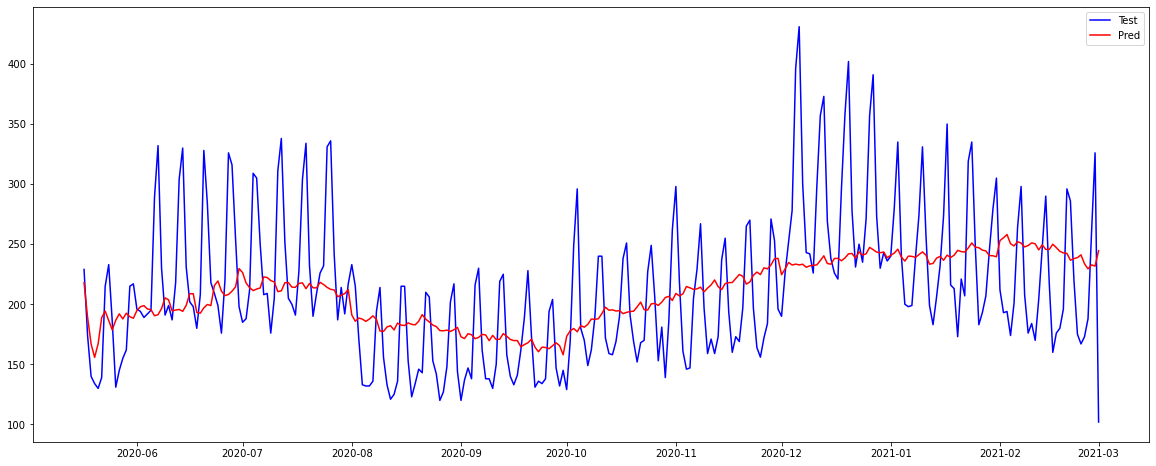

In [41]:
dict_name = {'Test': Y_test, "Pred": y_pred }
Test = pd.DataFrame(dict_name)

Test['Test'].plot(figsize=(20,8), legend=True, color='blue')
Test['Pred'].plot(legend=True, color='red', figsize=(20,8))

The model does not present the response to the daily peaks, however we can see that it can model the mean properly, and we will use the monthly value to estimate the pickers of each shift

## Predicting March Values

let's create the exog data for the month to predict 

In [43]:
future_month = pd.date_range(start='03-02-2021', periods=30).to_frame()
future_month.rename(columns={0:'Date_Index'}, inplace=True)
future_month['month']     = future_month.Date_Index.dt.month
future_month['year']      = future_month.Date_Index.dt.year
future_month['sin180']    = np.sin(2 * np.pi * future_month.index.dayofyear / 180)
future_month['cos180']    = np.cos(2 * np.pi * future_month.index.dayofyear / 180)
future_month = future_month.merge(impact[['affectednes','year','month']], how='left', on=['year','month'])
future_month.drop(['month', 'year', 'Date_Index'], axis = 1, inplace  = True)
future_month.index  = pd.date_range(start='03-02-2021', periods=30)
future_month.head(1)

,sin180,cos180,affectednes
2021-03-02,0.848048,-0.529919,0


In [45]:
exog_future = pd.concat([exog_test, future_month, ], axis =0)

In [52]:
prediction = results.get_forecast(steps=319, exog=exog_future)

<AxesSubplot:>

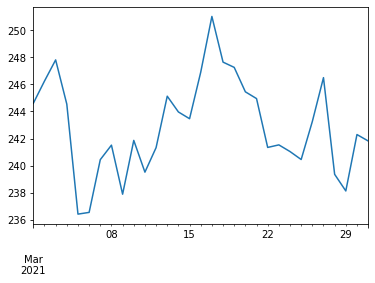

In [53]:
y_pred = prediction.predicted_mean
y_pred = y_pred.iloc[288:319]
y_pred.plot()

In [54]:
table['Morning_shift']   = table['Morning']   / table['Total']
table['Afternoon_shift'] = table['Afternoon'] / table['Total']
table[['Morning_shift', 'Afternoon_shift']].describe().loc['mean']
Morning_shift   = table[['Morning_shift', 'Afternoon_shift']].describe().loc['mean'][0]
Afternoon_shift = table[['Morning_shift', 'Afternoon_shift']].describe().loc['mean'][1]

In [55]:
Morning_orders   = Morning_shift   * y_pred.mean()
Afternoon_orders = Afternoon_shift * y_pred.mean()

Now let's convert the orders per shift to required staff using the minimum work ratio per operator. the minimum work ratio of orders picked per hour is 5, and since each shift is 6 hour long, we have a minumum of 30 orders per shift picked by operator.

In [56]:
morning_pickers   = floor(Morning_orders/30)
afternoon_pickers = floor(Afternoon_orders/30)

In [57]:
morning_pickers

3

In [58]:
afternoon_pickers

4

## Conclusions!
According to the analysis carried out in this notebook, the recommendation for the ABC company in order to satisfy the fulfillment of all the orders in an efficient way is to hire for the month of March: 3 operators for the morning shift and 4 for the afternoon shift.

In a further analysis, it would be convenient to approach in greater detail the estimation of the minimum work ratio, since it is the final determinant in the number or operators needed for the optimal operation of the orders enlisting process.